# Vardaan Tekriwal
### 24th December 2023

# i. Introduction

Undertaken as part of the EECS 16B – Designing Information Devices and Systems II – course at the University of California, Berkeley, our project was to construct a voice-controlled car from scratch, where this notebook is a compilation of the workings of myself, Vardaan Tekriwal, and my partners, Siddharth Mishra and Cheyenne Arnold. **I primarily worked on the mathematical workings and Python programming; hence I focus this report as such, omitting several portions of the hands-on aspects conducted by the team.** I acknowledge the immeasurable support of the current and past EECS 16B course staff (refer to Section 12) as well as my team members throughout this project.

**Key Words:** Machine Learning, SVD, PCA, k-NN, Euclidean Classifier, System ID, Control Systems, Closed Loop Feedback, Classification, Stability, Data Engineering, Electrical Engineering, Discretization, Regression Analysis, Frequency Response, Filters

# ii. Table of Contents

### 1. Frequency Response of the Microphone
* 1.1 Initial Test
* 1.2 Low Pass Filter (First Order) 
* 1.3 Notch Filter (Second Order)

### 2. Sensor (Encoder) Verification

### 3. Open Loop Feedback and Parameter Estimation
* 3.1 Coarse Data Collection
* 3.2 Fine Data Collection
* 3.3 Least Squares
* 3.4 Evaluating the Fit
* 3.5 Determining the Operating Point

### 4. Open Loop Control
* 4.1 Open Loop Controller Design 
* 4.2 Model Mismatch
* 4.3 Jolt Calculation
* 4.4 Open Loop Implementation

### 5. Closed Loop Control
* 5.1 Closed Loop Design
* 5.2 Closed Loop Simulation and f-Value Selection
* 5.3 Steady State Error Correction
* 5.4 Closed Loop Implementation

### 6. Turning
* 6.1 Analysing a Turn
* 6.1 Turn Implementation

### 7. Vocal Data Collection and Pre-Processing

### 8. Vocal Data Processing
* 8.1 Splitting the Data (Train and Test) 
* 8.2 Aligning the Audio Recording

### 9. Principal Component Analysis via Singular Value Decomposition
* 9.1 Processing the Input for PCA
* 9.2 Singular Value Decomposition  
* 9.3 Principal Component Analysis
* 9.4 Basis Selection using Principal Components
* 9.5 Feature Selection 

### 10. Classification
* 10.1 Euclidean Classifier Set Up
* 10.2 Testing the Euclidean Classifier
    * 10.2.1 Raw Test Data 
    * 10.2.2 Enveloping and Trimming the Test Data
    * 10.2.3 Projecting the Test Data 
    * 10.2.4 Euclidean Classification of the Test Data
* 10.3 k-NN Classifier Set Up
* 10.4 Testing the k-NN Classifier
* 10.5 PCA & Classification Implementation

### 11. Real World Implementation

### 12. Acknowledgements


# 1. Frequency Response of the Microphone

## 1.1 Initial Test

At this point, we've built our chassis and have tuned our circuits including the mic board, Arduino, Bipolar Junction Transistor, encorders, motors, and other basic circuit elements. We now need to test our microphone and determine its response to different frequencies. We use an oscilloscope to measure the peak-to-peak voltage output, ($V_{out}$) in the dictionary `freq_Vpp` below.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
import math
from pylab import * 
import scipy.io
import csv
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
cm = ['blue', 'red', 'green', 'orange', 'black', 'purple']

Vpp =  [1.4, 1.6, 1.9, 2.6, 2.4, 5, 4.8, 5, 4.9, 4.6, 3.4, 3.5, 5, 5, 3.9, 1.5, 1]


Text(0, 0.5, 'Gain (Volts/Volts)')

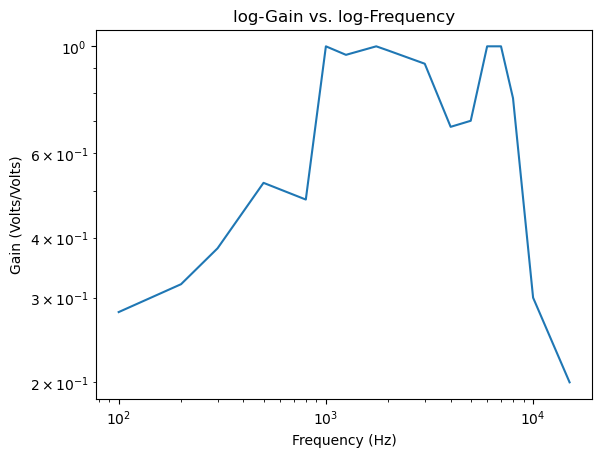

In [5]:
freq_Vpp = {
    100: 1.4,
    200: 1.6, 
    300: 1.9, 
    500: 2.6, 
    800: 2.4, 
    1000: 5, 
    1250: 4.8, 
    1750: 5, 
    2000: 4.9,  
    3000: 4.6, 
    4000: 3.4, 
    5000: 3.5, 
    6000: 5, 
    7000: 5, 
    8000: 3.9,
    10000: 1.5,
    15000: 1
}
freq = sorted(list(freq_Vpp.keys()))
Vpp = [freq_Vpp[f] for f in freq] 
print("Vpp = ", Vpp)

# We do not have a measurable input signal Vin, so we normalize the maximum of the frequency response to 1.
gain = np.array(Vpp)/max(Vpp)

plt.loglog(freq, gain)
plt.title('log-Gain vs. log-Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (Volts/Volts)')

## 1.2 Low Pass Filter (First Order)

Since we are designed a voice controlled car, we want to design a low pass (LP) filter such that the cutoff frequency is around 2,500 Hz, the upper bound for vocal frequencies. We use the RC model for an LP filter, so we choose our values for $R$ and $C$ accordingly. We use a function generator to output a sinusoid with a 2.5V offset, 1V peak-to-peak voltage, and the frequency as the cutoff frequency of your low pass filter. We expect the output at the cutoff range to be $V_{pp}$ should be $\frac{1}{\sqrt 2} \cdot V_{pp}$. 

In [ ]:
R = 6200
C = 1* 10**-8
f_c = 1/(2*math.pi*R*C) #method of calculating the cutoff frequency for an RC circuit

print("Low pass filter")
print("===============")
print("Resistor: {} ohms".format(R))
print("Capacitor: {} farads".format(C))
print("Cutoff frequency: {} Hz".format(f_c))

We multiply the ideal low-pass filter frequency response (`lp_p2p_expected`) with our observed speaker-mic board frequency response (the variable called gain), and the satisfies a sanity check.

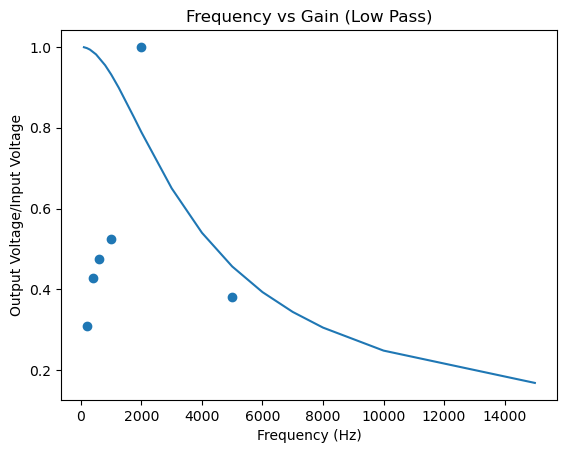

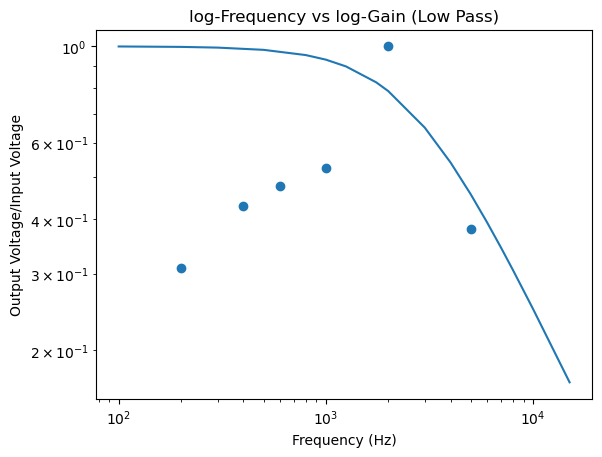

In [14]:
low_cutoff = float(2567.0) #TODO
lp_p2p_expected = 1/(np.sqrt(1+((np.array(freq)/(low_cutoff))**2)))

lp_freq_Vpp = {
    200: 1.3,
    400: 1.8, 
    600: 2.0, 
    1000: 2.2, 
    2000: 4.2,
    5000: 1.6
}
lp_freqs = sorted(list(lp_freq_Vpp.keys()))
lp_p2p_observed = [lp_freq_Vpp[f] for f in lp_freqs]
lp_gain_observed = np.array(lp_p2p_observed)/np.max(lp_p2p_observed)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Output Voltage/Input Voltage")
plt.title("Frequency vs Gain (Low Pass)")
plt.plot(freq, lp_p2p_expected)
plt.scatter(lp_freqs, lp_gain_observed)
plt.show()

plt.xlabel("Frequency (Hz)")
plt.ylabel("Output Voltage/Input Voltage")
plt.title("log-Frequency vs log-Gain (Low Pass)")
plt.loglog(freq, lp_p2p_expected)
plt.scatter(lp_freqs, lp_gain_observed)
plt.show()

## 1.3 Notch Filter (Second Order)

We connect a high pass filter and a low pass filter with a unity gain buffer to get a notch filter (i.e. a filter that passes all frequencies except for a frequency of our choice). While not of utmost importance, we need this filter in the case that there is a parasitic frequency in the environment. We use the L-R-C design, where we choose $L$, $R$, and $C$ to obtain a notch frequency between 500-5000 Hz.

In [10]:
R = 51
L = 0.0033
C = 0.000001
f_c = 1/(2*math.pi*math.sqrt(L*C)) #method of calculating the cutoff frequency for an LRC circuit

print("Notch filter")
print("================")
print("Resistor: {} ohms".format(R))
print("Inductor: {} henries".format(L))
print("Capacitor: {} farads".format(C))
print("Notch frequency: {} Hz".format(f_c))

Notch filter
Resistor: 51 ohms
Inductor: 0.0033 henries
Capacitor: 1e-06 farads
Notch frequency: 2771.9371967467805 Hz


We test this filter at a handful of key points and observe that it works as intended.

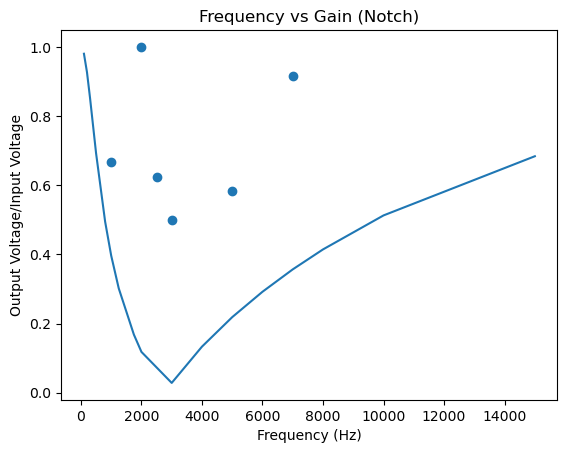

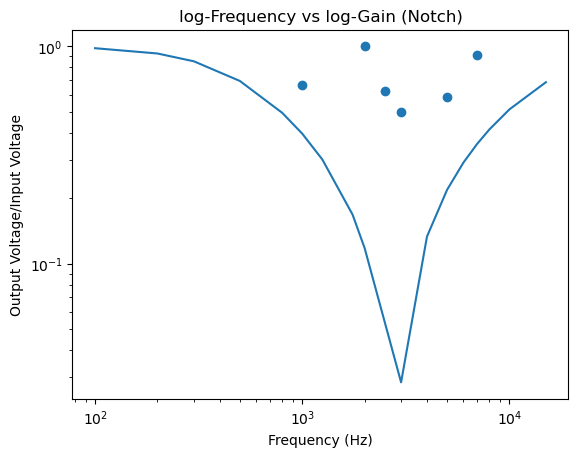

In [12]:
notch_freq = float(2771)
notch_p2p_expected = np.abs(np.array(freq)-notch_freq**2/np.array(freq))/(np.sqrt((R/L)**2 + (np.array(freq)-notch_freq**2/np.array(freq))**2))

notch_freq_Vpp = {
    1000: 1.6,
    2000: 2.4,
    2500: 1.5,
    3000: 1.2,
    5000: 1.4,
    7000: 2.2
}
notch_freqs = sorted(list(notch_freq_Vpp.keys()))
notch_p2p_observed = [notch_freq_Vpp[f] for f in notch_freqs]
notch_gain_observed = np.array(notch_p2p_observed)/np.max(notch_p2p_observed)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Output Voltage/Input Voltage")
plt.title("Frequency vs Gain (Notch)")
plt.plot(freq, notch_p2p_expected)
plt.scatter(notch_freqs, notch_gain_observed)
plt.show()

plt.xlabel("Frequency (Hz)")
plt.ylabel("Output Voltage/Input Voltage")
plt.title("log-Frequency vs log-Gain (Notch)")
plt.loglog(freq, notch_p2p_expected)
plt.scatter(notch_freqs, notch_gain_observed)
plt.show()

# 2. Sensor (Encoder) Verification

Procedure: 

1. Connect the Arduino to the computer.
2. Power the motors with 9V from the +25V channel on the power supply, and set the current limit to 0.4A 
3. Power the regulator input with the same +25V channel on the power supply
4. Upload **`encoder_test_0_ticks.ino`** to the Arduino.
5. Open the serial monitor and set the baud rate to `38400`
7. Follow the instructions on the serial monitor.

The test is designed in 4 phases: both wheels at rest, only left wheel driving, only right wheel driving, and both wheels driving. Our car worked as intended.

# 3. Open Loop Feedback and Parameter Estimation

## 3.1 Coarse Data Collection

We denote the following greeks to denote:

$θ$ - the absolute change in velocity per unit increase in the PWM input, i.e. the “sensitivity” of the motors. 

$β$ - the systematic constant velocity offset, i.e. the input required to overcome static friction and other parasitic external factors

$δ$ – the difference in distance traveled between the left and right wheels of the car

Since we want to get a general idea of how the motors react to different inputs, as well as systematic mechanical abberations between the two motors, we test run our car with a large set of PWM inputs. We do this with `dynamics_data.ino`, and we paste the data into the `data_coarse.txt` file. Our PWM input is dictated by **`SID1`**.

We plot the data below. Note that 'ascending' entails that the car is speeding up, whereas 'descending' means that the car is slowing down.

In [ ]:
with open('data_coarse.txt', 'r') as file:
    data = np.array([[int(num) for num in line.strip().split(',')] for line in file.readlines()])

# compute velocity from the distances 
vleft  = data[:, 1]
vright = data[:, 2]

u = data[:, 0].reshape((-1, 1)) # duty cycle
left_des, left_asc = np.array_split(vleft, 2)
right_des, right_asc = np.array_split(vright, 2)
u_des, u_asc = np.array_split(u, 2)

plt.plot(u_des, left_des, 'b-',  u_des, right_des, 'y-')
plt.plot(u_asc, left_asc, 'b-o',  u_asc, right_asc, 'y-^')
plt.xlabel("u (input via PWM)")
plt.ylabel("Velocity of Wheels")
labels = ("left (descending)", "right (descending)",
          "left (ascending)" , "right (ascending)")
plt.legend(labels, loc=0)
plt.show()

<img width="575px" src="3_1.png" align='left'>

## 3.2 Fine Data Collection

Since we have a general idea of the way tht our voice-controlled car drives, we now collect data for a small range of velocities – therefore PWM – (as is intended for normal operation) for us to then run least squares. We do this by switching to the **`SID2`** with `dynamics_data.ino`, and we store the data in the `data_fine.txt` file. 

The data is plotted below for reference.

<img width="575px" src="3_2.png" align='left'>

## 3.3 Least Squares

In [ ]:
def identify_parameters(u, v):
    ones = -1 * np.ones(np.shape(np.vstack(u)))
    data = np.hstack((np.vstack(u), ones))
    lstsq = np.linalg.lstsq(data, v)
    return lstsq[0][0], lstsq[0][1]

theta_left, beta_left = identify_parameters(u, vleft)
theta_right, beta_right = identify_parameters(u, vright)

print("float theta_left = {:.4g};".format(theta_left))
print("float theta_right = {:.4g};".format(theta_right))
print("float beta_left = {:.4g};".format(beta_left))
print("float beta_right = {:.4g};".format(beta_right))

In [ ]:
u = u.reshape(-1)
vleft_LS = theta_left*u-beta_left
vright_LS = theta_right*u-beta_right
plt.plot(u, vleft, 'bo',  u, vright, 'yo', u, vleft_LS, 'b-', u, vright_LS, 'y-')
plt.xlabel("u (input via PWM)")
plt.ylabel("Velocity of Wheels")
plt.legend(("left", "right"), loc=0)

<img width="575px" src="3_3.png" align='left'>

## 3.4 Evaluating the Fit

We want to see whether there are some values for which both wheels have the same velocity in order to determine an operating point that is viable. We note that if one does not exist, then we would be unable to determine an appropriate operating point. Also, to test the accuracy of $θ$ and $β$, we simulate our collected data with the expected data using the parameters.

In [ ]:
# model
def sim(d0, u, theta, beta):
    d = np.zeros(len(u)+1)
    d[0] = d0
    for t in range(len(u)):
        d[t+1] = d[t] + theta*u[t] - beta
    return d


def get_distances_from_velocities(v):
    d = np.zeros(len(u) + 1)
    d[0] = 0
    for t in range(len(u)):
        d[t+1] = d[t] + v[t] 
    return d
        
    
# plot
dleft = get_distances_from_velocities(vleft)
dright = get_distances_from_velocities(vright)

dleft_simulated  = sim(0, u, theta_left, beta_left)
dright_simulated = sim(0, u, theta_right, beta_right)
plt.plot(dleft, 'b.', 
         dright, 'y.',
         dleft_simulated, 'b-', 
         dright_simulated, 'y-',
        )


plt.xlabel("time")
plt.ylabel("distance")
plt.legend(("left (data)", "right (data)", "left (fit)", "right (fit)"), loc='upper left')

<img width="575px" src="3_4.png" align='left'>

## 3.5 Determining the Operating Point

Due to idiosyncratic and systematic errors, the operating range of velocities for either wheel are different. But in order for the car to drive straight, both must move at the same velocity. Thus, we set the operating point of the system to a velocity that is feasible for both wheels. This is why we require both wheels to have a common achievable velocity. To maximize the range, we choose the midpoint of the overlapping range as the operating velcoity.

In [26]:
min_vel = max(min(vleft_LS), min(vright_LS))
max_vel = min(max(vleft_LS), max(vright_LS))

if ((min(vleft_LS) > max(vright_LS)) or (min(vright_LS) > max(vleft_LS))):
    print('Error: Velocity ranges of left and right wheels do not overlap. Recollect data_fine with a wider PWM range')
else:
    print('Velocity range = [{:0.1f}, {:0.1f}]'.format(min_vel, max_vel))
    midpoint = (min_vel+max_vel)/2
    print('\nOperating point:\nfloat v_star = {:.1f};'.format(midpoint))

    u = u.reshape(-1)
    vleft_LS = theta_left*u-beta_left
    vright_LS = theta_right*u-beta_right
    plt.plot(u, vleft_LS, 'b-', u, vright_LS, 'y-')
    for i in (min_vel, max_vel):
        plt.plot(u, 0*u + i, 'g-')
    plt.plot(u, vleft, 'bo',  u, vright, 'yo')
    plt.xlabel("u (input via PWM)")
    plt.ylabel("Velocity of Wheels")
    plt.legend(("left", "right", "overlap"), loc=0)

Velocity range = [66.7, 80.0]

Operating point:
float v_star = 73.3;


<img width="575px" src="3_5.png" align='left'>

# 4. Open Loop Control

In [30]:
#Our calculated parameters
theta_left = .3031
theta_right = .2664
beta_left = -32.56
beta_right = -37.35
v_star = 73.3

params = np.array([(theta_left, theta_right), (beta_left, beta_right)])
d0 = (0,  0)
sim_length = 10 # sim length
mismatch_error = 0.1 # 10% model mismatch

## 4.1 Open Loop Controller Design

We use the calculated parameters to adjust our motors intrinsic velocity to our target velocity. Essentially, we are adjusting either wheel's velocity when driving straight to our calculated `v_star`.

In [29]:
def drive_straight_left_ol(v_star):
    return (v_star + beta_left)/theta_left

def drive_straight_right_ol(v_star):
    return (v_star + beta_right)/theta_right

## 4.2 Model Mismatch

There could be a mismatch between the estimated model parameters $\beta_{L,R}, \theta_{L,R}$ and real model parameters $\beta^*_{L,R}, \theta^*_{L,R}$ since we assumed that the mismatch error is identical for both $\beta_{L,R}$ and $\theta_{L,R}$


$$\theta^*_{L,R}=\theta_{L,R} \times (1+\text{mismatch_error})$$
$$\beta^*_{L,R}=\beta_{L,R} \times (1+\text{mismatch_error})$$


<img width="575px" src="4_2_1.png" align='left'>


<img width="575px" src="4_2_2.png" align='left'>

On the left, we assume that the physical system is identical to our model, whereas on the right we assume that the system is 10% (the mismatch error) different from our model (i.e. the parameters have a mismatch). We also plot the trajectory of the car depending on the utilized model.


 






## 4.3 Jolt Calculation

When starting our motors from rest, because of static friction, we need to apply a large initial PWM, i.e. "jolt" the motors. But since each side responds differently to an input, applying a constant value could cause the car to immediately turn. Hence, we calculate the jolt values that would result in the same velocity, which we choose to be the maximum velocity in the overlapping range. 

<img width="575px" src="4_3.png" align='left'>


## 4.4 Open Loop Implementation

Refer to the **`open_loop.ino`** code for the final implementation of the Open Loop Control system.

# 5. Closed Loop Control

We need to detect whether the car is turning – an apparent limitation of the open loop system. To account for this, we can take the data from the encoders and feed it back into our system to preserve the intendend trajectory.

## 5.1 Closed Loop Design

We define $\delta[i] = d_L[i] - d_R[i]$, to be the difference between the data from the encoder (i.e. the distances traveled) for the left and right wheels.
Our design takes the $\delta$ value and adjusts the left and right inputs to correct for turns or disturbances. We define feedback factors $f_{left}$ and $f_{right}$ to control the amount of correction of each wheel.

In [ ]:
def drive_straight_left_cl(v_star, delta):
    return drive_straight_left_ol(v_star)-(f_left/theta_left)*delta

def drive_straight_right_cl(v_star, delta):
    return  drive_straight_right_ol(v_star)+(f_right/theta_right)*delta

## 5.2 Closed Loop Simulation and f-Value Selection

In [43]:
f_values = {
    "marginally stable": (-0.3, 0.3),
    "stable, corrects error in one step": (0.5, 0.5),
    "oscillatory, marginally stable": (1, 1),
    "oscillatory, unstable": (1.1, 1.1),
    "stable": (0.2, 0.2),
}

for key in f_values:
    f_left, f_right = f_values[key]

    titles = ["Closed-loop control with perfect model",
              "Closed-loop control with model mismatch, fL={}, fR={}".format(f_left, f_right)]
    _, delta = utils.two_sims(titles, simulator, v_star, drive_straight_left_cl, drive_straight_right_cl)

    print("fL={}, fR={}".format(f_left, f_right))
    print("Eigenvalue of system: 1-fL-fR={:.2g}; {}".format(1-f_left-f_right, key))
    plt.show()
    steady_state_error = delta[-1]

1.
Perfect model: Steady state error = 4.57
Non-ideal model: Steady state error = unbounded
fL=-0.3, fR=0.3
Eigenvalue of system: 1-fL-fR=1; marginally stable

2.
Perfect model: Steady state error = 0.00 
Non-ideal model: Steady state error = 14.66
fL=0.5, fR=0.5
Eigenvalue of system: 1-fL-fR=0; stable, corrects error in one step

3.
Perfect model: Steady state error = oscillatory
Non-ideal model: Steady state error = oscillatory
fL=1, fR=1
Eigenvalue of system: 1-fL-fR=-1; oscillatory, marginally stable

4.
Perfect model: Steady state error = unbounded
Non-ideal model: Steady state error = unbounded
fL=1.1, fR=1.1
Eigenvalue of system: 1-fL-fR=-1.2; oscillatory, unstable

5.
Perfect model: Steady state error = 0.00
Non-ideal model: Steady state error = 36.47
fL=0.2, fR=0.2
Eigenvalue of system: 1-fL-fR=0.6; stable



<img width="575px" src="5_2_1.png" align='left'>

<img width="575px" src="5_2_2.png" align='left'>

<img width="575px" src="5_2_3.png" align='left'>

<img width="575px" src="5_2_4.png" align='left'>

<img width="575px" src="5_2_5.png" align='left'>


Our system's eigenvalue $\lambda$ is such that $\lambda = 1 - f_{left} - f_{right}$. In order for our system to be stable, $|\lambda| < 1$. From the graphs and data above, we deduce that we take $f_{left} = 0.9$ and $f_{right} = 0.9$. This means that $|\lambda| = 0.8 < 1$, therefore is stable. Another possible way to view this is by rearranging the terms to get $0 < f_{left} + f_{right} < 2$.

In [44]:
f_left, f_right = .9, .9 

print("fL={}, fR={}".format(f_left, f_right))
print("Eigenvalue of system: 1-fL-fR={:.2g}; {}".format(1-f_left-f_right, key))
plt.show()
steady_state_error = delta[-1]

Perfect model: Steady state error = unbounded
Non-ideal model: Steady state error = unbounded
fL=0.9, fR=0.9
Eigenvalue of system: 1-fL-fR=-0.8; stable


<img width="575px" src="5_2_6.png" align='left'>

## 5.3 Steady State Error Correction

It is possible that the convergence of $\delta$ is to a constant non-zero value. We offset this by including an offseting constant $\delta_{ss}$, where our new error term becomes $\delta[i]=d_L - d_R + \delta_{ss}$.

In [46]:
plt.figure(figsize=(5, 7))
plt.subplot(211)
# Simulate using steady_state_error
d = simulator.simulate(
    v_star, drive_straight_left_cl, drive_straight_right_cl, mismatch_error=0.1, sim_length=20, offset=steady_state_error)
delta = simulator.plot(d)
plt.title("Closed-loop control with model mismatch and\nsteady state error correction, fL={}, fR={}"
          .format(f_left, f_right))
plt.subplot(212)
plt.plot(delta, 'r')
plt.ylabel('delta')
plt.xlabel('n(sample)')
plt.grid()

Steady state error = unbounded


<img width="575px" src="5_4.png" align='left'>

## 5.4 Closed Loop Implementation

Refer to the **`closed_loop.ino`** code for the final implementation of the Closed Loop Control system.

# 6. Turning

## 6.1 Analysing a Turn

<img width="575px" src="6_1.png" align='left'>

With the diagram above, we can write $\delta[i] = \frac{l \cdot v^* \cdot i}{r}$

Our implementations of data collection and control loop have different time periods: data collection is on half-second intervals, while our controller updates the trajectory every 0.1 seconds. Since we define the time step as being dependent on the samping period, we need to account for this difference by adjusting $v^*$ while turning. If we don't, we effectively quintupe our velocity.

Let the sampling periods of the control loop and the data collection be $T_c$ and $T_d$, which have the units $\frac{s}{sample}$. Therefore, their respective sampling frequencies $F_c = \frac{1}{T_c}$ and $F_d = \frac{1}{T_d}$ have the units $\frac{samples}{s}$. We define $m=\frac{F_c}{F_d}$, the ratio of the sampling frequencies.

Our controller interprets velocity in terms of distance traveled (measured in encoder ticks) per sample ($\frac{ticks}{sample}$). However, we need to ensure the car is travelling at the same ground velocity, which is measured per second ($\frac{ticks}{s}$). To get a constant $\frac{ticks}{s}$, we need $v^*_c \cdot F_c = v^* \cdot F_d$.

Solving for $v^*_c$, we get $v^*_c = v^* \cdot \frac{F_d}{F_c} = \frac{v^*}{m}$

Plugging in our values of $T_c=100ms$ and $T_d=500ms$, we can calculate that $F_c=10$, $F_d=2$, and $m=5$.

## 6.1 Turn Implementation

Refer to the **`turning.ino`** code for the final implementation of the Turning system.

# 7. Vocal Data Collection and Pre-Processing

We choose 6 unique words, ones with distinct features (including intonation, syllables, and magnitude), for our voice-controlled car to classify. We chose back, forward, banana, apple, right, pear. We speak each distinct word 40 times and gather record the data through the following procedure:

1. Upload **`collect-data-envelope.ino`** to the Arduino.
2. Read in Arduino data using your computer
3. Run the Git Bash line **`python collect-data-envelope.py WORD.csv`** in the terminal
4. Record 40 good samples and terminate the program

Once all words have been recorded, we compile all data to `PCA_data`. Note than an enveloping function is run automatically by the Arduino.




# 8. Vocal Data Processing

## 8.1 Splitting the Data (Train and Test)

We split our data 70/30 into a train set and test set, and plot the training data to visualize the enveloped version.

In [16]:
all_words_arr = ['back', 'forward', 'banana', 'watermelon', 'turnleft', 'apple']
train_test_split_ratio = 0.7
train_dict = {}
test_dict = {}

for i in range(len(all_words_arr)):
    word_raw = utils.read_csv("PCA_data/{}.csv".format(all_words_arr[i]))
    word_raw_train, word_raw_test = utils.train_test_split(word_raw, train_test_split_ratio)
    train_dict[all_words_arr[i]] = word_raw_train
    test_dict[all_words_arr[i]] = word_raw_test

# Count the minimum number of samples across the six recorded words
num_samples_train = min(list(map(lambda x : np.shape(x)[0], train_dict.values())))
num_samples_test = min(list(map(lambda x : np.shape(x)[0], test_dict.values())))

# Crop the number of samples for each word to the minimum number so all words have the same number of samples.
for key, raw_word in train_dict.items():
    train_dict[key] = raw_word[:num_samples_train,:]

for key, raw_word in test_dict.items():
    test_dict[key] = raw_word[:num_samples_test,:]
    
word_number = 0
selected_words_arr = all_words_arr
for word_raw_train in train_dict.values():
    plt.plot(word_raw_train.T)
    plt.title('Training sample for "{}"'.format(selected_words_arr[word_number]))
    word_number += 1
    plt.show()

<img width="575px" src="8_1_1.png" align='left'>

<img width="575px" src="8_1_2.png" align='left'>

<img width="575px" src="8_1_3.png" align='left'>

<img width="575px" src="8_1_4.png" align='left'>

<img width="575px" src="8_1_5.png" align='left'>

<img width="575px" src="8_1_6.png" align='left'>


## 8.2 Aligning the Audio Recording

As witnessed by the graphs, the instances of a word comprise a fraction of the 2 second window, where every sample starts at different times. We use a thesholding algorithm to align the recordings and trim to the desired segments. 

First, we define a **`threshold`** relative to the maximum value of the data; any signal that crosses this value is the start of an instance. But in order to not lose the first couple data points of the instance, we say that the instance starts **`pre_length`** samples _before_ the threshold is crossed. We then use a window of the data that is **`length`** long, and try to capture the entire command in that window.

In [ ]:
def get_snippets(data, length, pre_length, threshold):
    """
    Args:
        data (np.ndarray): Matrix where each row corresponds to a recording's audio samples.
        length (int): The length of each aligned audio snippet.
        pre_length (int): The number of samples to include before the threshold is first crossed.
        threshold (float): Used to find the start of the speech command. The speech command begins where the
            magnitude of the audio sample is greater than (threshold * max(samples)).
    
    Returns:
        Matrix of aligned recordings.
    """
    assert isinstance(data, np.ndarray) and len(data.shape) == 2, "'data' must be a 2D matrix"
    assert isinstance(length, int) and length > 0, "'length' of snippet must be an integer greater than 0"
    assert 0 <= threshold <= 1, "'threshold' must be between 0 and 1"
    snippets = []

    # Iterate over the rows in data
    for recording in data:
        # Find the threshold
        recording_threshold = threshold * np.max(recording)

        # Figure out when interesting snippet starts
        i = pre_length
        while recording[i] < recording_threshold:
            i += 1
            
        snippet_start = min(i - pre_length, len(recording) - length)
        snippet = recording[snippet_start:snippet_start + length]

        # Normalization
        snippet = snippet / np.sum(snippet)
        
        snippets.append(snippet)

    return np.vstack(snippets)

In [ ]:
def process_data(dict_raw, length, pre_length, threshold, plot=True):
    """
    Process the raw data given parameters and return it.
    
    Args:
        dict_raw (np.ndarray): Raw data collected.
        data (np.ndarray): Matrix where each row corresponds to a recording's audio samples.
        length (int): The length of each aligned audio snippet.
        pre_length (int): The number of samples to include before the threshold is first crossed.
        threshold (float): Used to find the start of the speech command. The speech command begins where the
            magnitude of the audio sample is greater than (threshold * max(samples)).
        plot (boolean): Plot the dataset if true.
            
    Returns:
        Processed data dictionary.
    """
    processed_dict = {}
    word_number = 0
    for key, word_raw in dict_raw.items():
        word_processed = get_snippets(word_raw, length, pre_length, threshold)
        processed_dict[key] = word_processed
        if plot:
            plt.plot(word_processed.T)
            plt.title('Samples for "{}"'.format(selected_words_arr[word_number]))
            word_number += 1
            plt.show()
            
    return processed_dict 

In [ ]:
length = 80 
pre_length = 5
threshold = 0.5

processed_train_dict = process_data(train_dict, length, pre_length, threshold)

<img width="575px" src="8_2_1.png" align='left'>

<img width="575px" src="8_2_2.png" align='left'>

<img width="575px" src="8_2_3.png" align='left'>

<img width="575px" src="8_2_4.png" align='left'>

<img width="575px" src="8_2_5.png" align='left'>

<img width="575px" src="8_2_6.png" align='left'>


# 9. Principal Component Analysis via Singular Value Decomposition

## 9.1 Processing the Input for PCA

Having aligned the data, the PCA input matrix is the data stacked vertically, where each data point is centered to zero with respect to its word (the feature at hand). This demeaned data is stored in `demeaned_A`.

In [ ]:
processed_A = np.vstack(list(processed_train_dict.values()))
mean_vec = np.mean(processed_A, axis = 0)
demeaned_A = np.zeros(np.shape(processed_A))
for i in np.arange(len(mean_vec)):
    demeaned_A[:, i] = processed_A[:, i] - mean_vec[i]

## 9.2 Singular Value Decomposition

In [ ]:
U, S, Vt = np.linalg.svd(demeaned_A, full_matrices=True)

## 9.3 Principal Component Analysis

In [ ]:
plt.stem(S)

<img width="575px" src="9_3.png" align='left'>

## 9.4 Basis Selection using Principal Components

We notice we run into memory issues when we select more than 3 principal components, so we select 3 principal components. 

In [ ]:
new_basis = U[:, 0:3]
plt.plot(new_basis)
plt.show()

<img width="575px" src="9_4_1.png" align='left'>

Projecting the data onto the new basis for three principal components and plotting it, we observe clustering, which indicates relative ease in classification.

In [ ]:
S_matrix = np.zeros([3, 80])
S_matrix[0:3, 0:3] = np.diag(S[0:3])
projected_A_train_pca = np.matmul(np.dot(new_basis, S_matrix), Vt[:, 0:3])

if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(all_words_arr)):
        Axes3D.scatter(ax, *proj[i*num_samples_train:num_samples_train*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(all_words_arr,loc='center left', bbox_to_anchor=(1.07, 0.5))
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(all_words_arr)):
        axs[0].scatter(projected_A_train_pca[i*num_samples_train:num_samples_train*(i+1),0], projected_A_train_pca[i*num_samples_train:num_samples_train*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(projected_A_train_pca[i*num_samples_train:num_samples_train*(i+1),0], projected_A_train_pca[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(projected_A_train_pca[i*num_samples_train:num_samples_train*(i+1),1], projected_A_train_pca[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(all_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,5))
    for i in range(len(all_words_arr)):
        plt.scatter(projected_A_train_pca[i*num_samples_train:num_samples_train*(i+1),0], projected_A_train_pca[i*num_samples_train:num_samples_train*(i+1),1], edgecolor='none')

    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

<img width="575px" src="9_4_2.png" align='left'>

<img width="900px" src="9_4_3.png" align='left'>

Having considered the possibility of noise, out of the 6 words, we plan on selecting 4 words: one for front, back, left, and right. Of course, it makes the most sense for us to select words that are decoupled from one-another. For this matter, we select the following words: **apple, back, watermelon, forward**.

In [57]:
selected_words_arr = ['apple', 'back', 'watermelon', 'forward']

# Select data
selected_train_dict = {k: train_dict[k] for k in selected_words_arr}
selected_processed_train_dict = {k: processed_train_dict[k] for k in selected_words_arr}
selected_test_dict = {k: test_dict[k] for k in selected_words_arr}

num_samples_train = min(list(map(lambda x : np.shape(x)[0], selected_train_dict.values())))
num_samples_test = min(list(map(lambda x : np.shape(x)[0], selected_test_dict.values())))
print(num_samples_train)
# Reconstruct and demean data based on 4 chosen words.
# Zero-mean the matrix new A

processed_A = np.vstack(list(selected_processed_train_dict.values()))
mean_vec = np.mean(processed_A, axis = 0)
demeaned_A = np.zeros(np.shape(processed_A))
for i in np.arange(len(mean_vec)):
    demeaned_A[:, i] = processed_A[:, i] - mean_vec[i]
print(demeaned_A[0:3])
print(processed_A.shape)
print(mean_vec.shape)
print(demeaned_A.shape)

28
[[ 5.45866656e-04 -8.30246258e-04 -5.66929895e-04  5.97065362e-03
   1.03615163e-02  3.92135562e-03  8.55404146e-03  5.48640635e-03
   2.54795904e-03  1.05741826e-02  1.20035072e-02  9.89443084e-03
   1.61579993e-02  5.89428955e-03  4.17251987e-04 -1.55405127e-02
  -1.50935423e-02 -1.46804729e-02 -1.41781775e-02 -1.19595075e-02
  -1.32983646e-02 -1.24840074e-02 -9.95157114e-03 -7.99442838e-03
   4.70186879e-04  1.43503994e-02  1.06886074e-02  1.60220319e-02
   1.14706576e-02  1.24094360e-02  1.63036394e-02  8.55003025e-03
   1.00770244e-02  3.34911966e-03  2.17762606e-03  4.20621205e-03
   1.03256494e-03 -4.14173428e-05  8.12913862e-04 -2.34808405e-03
  -8.48768257e-03 -4.72715714e-03 -6.57054558e-03 -5.03694908e-03
  -7.07778354e-03 -6.31234630e-03 -4.06982358e-03 -3.70843252e-03
  -2.63266412e-03 -3.73696433e-03 -5.03425809e-03 -2.17942939e-03
  -5.02052350e-03 -2.05072953e-04 -3.80087105e-03 -2.56039370e-03
  -2.34797960e-03 -3.51507403e-03 -2.04205159e-03 -2.65187589e-03
  -4.96

## 9.5 Chosen Features 

To proceed with further analysis, we need to first repeat the same process as above, but only for the four words that we have selected.

In [ ]:
U, S, Vt = np.linalg.svd(demeaned_A, full_matrices=True)
new_basis = U[:, 0:3]
S_matrix = np.zeros([3, 80])
S_matrix[0:3, 0:3] = np.diag(S[0:3])
projected_A_train = np.matmul(np.dot(new_basis, S_matrix), Vt[:, 0:3])

if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *projected_A_train[i*num_samples_train:num_samples_train*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1.07, 0.5))
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(selected_words_arr)):
        axs[0].scatter(projected_A_train[i*num_samples_train:num_samples_train*(i+1),0], projected_A_train[i*num_samples_train:num_samples_train*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(projected_A_train[i*num_samples_train:num_samples_train*(i+1),0], projected_A_train[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(projected_A_train[i*num_samples_train:num_samples_train*(i+1),1], projected_A_train[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,5))
    for i in range(len(selected_words_arr)):
        plt.scatter(projected_A_train[i*num_samples_train:num_samples_train*(i+1),0], projected_A_train[i*num_samples_train:num_samples_train*(i+1),1], edgecolor='none')

    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

<img width="575px" src="9_5_1.png" align='left'>

<img width="900px" src="9_5_2.png" align='left'>

# 10. Classification

## 10.1 Euclidean Classifier Set Up

We define `find_centroids` to help us find the center of each cluster.

In [ ]:
def find_centroids(clustered_data, num_samples_train):
    centroids = []
    for i in range(4):
        centroids.append([np.mean(clustered_data[i*num_samples_train:(1+i)*num_samples_train, 0]), np.mean(clustered_data[i*num_samples_train:(1+i)*num_samples_train, 1]),np.mean(clustered_data[i*num_samples_train:(1+i)*num_samples_train, 2])])
    return centroids

In [59]:
centroid_list = np.vstack(centroids)
colors = cm[:(len(centroids))]

for i, centroid in enumerate(centroid_list):
    print('Centroid {} is at: {}'.format(i, str(centroid)))

if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *projected_A_train[i*num_samples_train:num_samples_train*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(selected_words_arr, loc='center left', bbox_to_anchor=(1.07, 0.5))
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *np.array([centroids[i]]).T, c=cm[i], marker = '*', s=300)
    plt.title("Training Data")
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(selected_words_arr)):
        axs[0].scatter(projected_A_train[i*num_samples_train:num_samples_train*(i+1),0], projected_A_train[i*num_samples_train:num_samples_train*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(projected_A_train[i*num_samples_train:num_samples_train*(i+1),0], projected_A_train[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(projected_A_train[i*num_samples_train:num_samples_train*(i+1),1], projected_A_train[i*num_samples_train:num_samples_train*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(selected_words_arr, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    axs[1].scatter(centroid_list[:,0], centroid_list[:,2], c=colors, marker='*', s=300)
    axs[2].scatter(centroid_list[:,1], centroid_list[:,2], c=colors, marker='*', s=300)
    plt.show()

elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,7))
    for i in range(len(selected_words_arr)):
        plt.scatter(projected_A_train[i*num_samples_train:num_samples_train*(i+1),0], projected_A_train[i*num_samples_train:num_samples_train*(i+1),1], c=colors[i], edgecolor='none')

    plt.scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Training Data")
    plt.show()

Centroid 0 is at: [0.00033477 0.00096202 0.00172841]
Centroid 1 is at: [ 6.61174371e-04  8.87147152e-05 -6.56680193e-04]
Centroid 2 is at: [3.44251211e-05 5.60634748e-04 1.10361939e-03]
Centroid 3 is at: [-0.00103037 -0.00161137 -0.00217535]


<img width="575px" src="9_6_1.png" align='left'>

<img width="900px" src="9_6_2.png" align='left'>

## 10.2 Testing the Euclidean Classifier

We classify each data point according to the centroid with the least Euclidian distance to it, but before we perform the classification, we perform the same preprocessing to the test data that we did to the training data (enveloping, demeaning, projecting onto the PCA basis). 

### 10.2.1 Raw Data

In [ ]:
word_number = 0
for word_raw_test in selected_test_dict.values():
    plt.plot(word_raw_test.T)
    plt.title('Test sample for "{}"'.format(selected_words_arr[word_number]))
    word_number += 1
    plt.show()

<img width="575px" src="9_7_1_1.png" align='left'>

<img width="575px" src="9_7_1_2.png" align='left'>

<img width="575px" src="9_7_1_3.png" align='left'>

<img width="575px" src="9_7_1_4.png" align='left'>


### 10.2.2 Enveloping and Trimming

In [ ]:
processed_test_dict = process_data(selected_test_dict, length, pre_length, threshold)

<img width="575px" src="9_7_2_1.png" align='left'>

<img width="575px" src="9_7_2_2.png" align='left'>

<img width="575px" src="9_7_2_3.png" align='left'>

<img width="575px" src="9_7_2_4.png" align='left'>


### 10.2.3 Projecting the Test Data

In [ ]:
selected_processed_test_dict = {k: processed_test_dict[k] for k in selected_words_arr}
processed_A_test = np.vstack(list(selected_processed_test_dict.values()))

In [ ]:
projected_mean_vec = mean_vec.dot(new_basis[0:80]) #
projected_A_test = processed_A_test.dot(new_basis[0:80]) #project test data onto the same basis as train data

#Zero mean the test data using projected_mean_vec
projected_A_test_pca = np.zeros(np.shape(projected_A_test))
for i in np.arange(len(projected_mean_vec)):
    projected_A_test_pca[:, i] = projected_A_test[:, i] - projected_mean_vec[i]
    
#Plot projections
if new_basis.shape[1] == 3:
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, * projected_A_test_pca[i*num_samples_test:num_samples_test*(i+1)].T, c=cm[i], marker = 'o', s=20)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1.07, 0.5))
    plt.title("Test Data")
    for i in range(len(selected_words_arr)):
        Axes3D.scatter(ax, *np.array([centroids[i]]).T, c=cm[i], marker = '*', s=300)
    
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    for i in range(len(selected_words_arr)):
        axs[0].scatter(projected_A_test_pca[i*num_samples_test:num_samples_test*(i+1),0], projected_A_test_pca[i*num_samples_test:num_samples_test*(i+1),1], c=cm[i], edgecolor='none')
        axs[1].scatter(projected_A_test_pca[i*num_samples_test:num_samples_test*(i+1),0], projected_A_test_pca[i*num_samples_test:num_samples_test*(i+1),2], c=cm[i], edgecolor='none')
        axs[2].scatter(projected_A_test_pca[i*num_samples_test:num_samples_test*(i+1),1], projected_A_test_pca[i*num_samples_test:num_samples_test*(i+1),2], c=cm[i], edgecolor='none')
    axs[0].set_title("View 1")
    axs[1].set_title("View 2")
    axs[2].set_title("View 3")
    plt.legend(selected_words_arr, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    axs[1].scatter(centroid_list[:,0], centroid_list[:,2], c=colors, marker='*', s=300)
    axs[2].scatter(centroid_list[:,1], centroid_list[:,2], c=colors, marker='*', s=300)
    fig.show()

elif new_basis.shape[1] == 2:
    fig=plt.figure(figsize=(10,7))
    for i in range(len(selected_words_arr)):
        plt.scatter(projected_A_test_pca[i*num_samples_test:num_samples_test*(i+1),0], projected_A_test_pca[i*num_samples_test:num_samples_test*(i+1),1], c=colors[i], edgecolor='none')

    plt.scatter(centroid_list[:,0], centroid_list[:,1], c=colors, marker='*', s=300)
    plt.legend(selected_words_arr,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Test Data")
    plt.show()

<img width="575px" src="9_7_3_1.png" align='left'>

<img width="900px" src="9_7_3_2.png" align='left'>

### 10.2.4 Euclidean Classification of the Test Data

We define the `euc_classify` function that takes in a data point after enveloping is applied and returns which word number it belongs to depending on the closed centroid in Euclidian distance.

In [ ]:
def euc_classify(data_point, new_basis, projected_mean_vec, centroids):
    projected_data_point = np.dot(data_point, new_basis)
    demeaned = projected_data_point - projected_mean_vec
    distances = list(map(np.linalg.norm, centroid_list - demeaned))
    return np.argmin(distances) + 1

In [64]:
correct_counts = np.zeros(4)

for (row_num, data) in enumerate(processed_A_test):
    word_num = row_num // num_samples_test + 1
    if euc_classify(data) == word_num:
        correct_counts[word_num - 1] += 1
        
for i in range(len(correct_counts)):
    print("Percent correct of word {} = {}%".format(i + 1, 100 * correct_counts[i] / num_samples_test))

Percent correct of word 1 = 100.0%
Percent correct of word 2 = 100.0%
Percent correct of word 3 = 100.0%
Percent correct of word 4 = 100.0%


Our classifier worked as intended. We now move on to the real world implementation

## 10.3 k-NN Classifier Set Up

Since we already have the projections of the test data onto the orthonormal basis defined by the principal components in Section 10.2.3, we calculate the distances of each of the test data to the retained training data points.

In [ ]:
def k_nearest_neighbors(train_data, test_data, train_dict, test_dict, k=3):
    distances = cdist(test_data, train_data, metric='euclidean')
    nearest_neighbors_indices = np.argsort(distances, axis=1)[:, :k]
    nearest_neighbors_classes = np.array([[train_labels[i] for i in neighbors] for neighbors in nearest_neighbors_indices])
    predicted_classes = np.array([np.argmax(np.bincount(neighbors)) for neighbors in nearest_neighbors_classes])
    return predicted_classes

## 10.4 Testing the k-NN Classifier

In [2]:
class_to_numeric = {class_label: i for i, class_label in enumerate(set(selected_processed_train_dict.values()))} 
train_labels = np.array([class_to_numeric[label] for label in selected_processed_train_dict.values()]) 
test_labels = np.array([class_to_numeric[label] for label in selected_processed_test_dict.values()])  
success_rate = np.zeros(5)  

i = 0 
for k in np.arange(1:10:2):     
    predicted_classes = k_nearest_neighbors(projected_A_train_pca, projected_A_test_pca, train_labels, test_labels, k)     
    success_rate[i] = 100*np.mean(predicted_classes == test_labels)     
    print("Percentage of Correct Classification with k = {}: {}%".format(k, success_rate[i]))     
    i = i+1

Percentage of Correct Classification with k = 1: 71.4%
Percentage of Correct Classification with k = 3: 78.5%
Percentage of Correct Classification with k = 5: 82.1%
Percentage of Correct Classification with k = 7: 78.5%
Percentage of Correct Classification with k = 5: 75.0%


The k-NN Classifier, while indicatory in some capacity, is not as accurate as the Euclidean Classifier. This is likely due to the fact that the clustering of each individual words are confounded to some degree. We can observe that this is true from the plots in Section 9.5. 

## 10.5 PCA & Classification Implementation

Refer to the **`classify.ino`** code for the implementation of the Classifier. We implement the Euclidean Classifier instead of the k-NN classifier because of the apparent increase in accuracy. 

# 11. Real World Implementation

Refer to the **`integrated.ino`** code for the final implementation of the voice-controlled car.

Ultimately, we decided to pair the following words with a direction: (forward, forward), (back, back), (apple, left), (watermelon, right). 

All of our real world testing yielded successes. We tested each word 8 times, in randomized order, and our car drove appropriately for each success. Note that we implemented the Euclidean Classifier instead of the k-NN Classifier.

We would like to guide special attention to two variables in **`integrated.ino`**. `EUCLIDEAN_THRESHOLD` and `LOUDNESS_THRESHOLD`. The former sets the maximum distance that the recording can be from any centroid after projection and demeaning. If it’s too far from the closest centroid, the recording is thrown away and not classified as an instruction. The latter sets the minimum amplitude/loudness of the recording before the recording is recognized as a word. Otherwise, it is discarded and treated as noise.

# 12. Acknowledgements

- Siddharth Mishra
- Cheyenne Arnold
- Junha Kim
- Ryan Ma
- Venkata Alapati
- Megan Zeng
- Kaitlyn Chan
- Steven Lu
- Rafael Calleja
- Miki Lustig
- Jessica Fan
- Yi-Hsuan Shih
- Hossein Najafi
- Mia Mirkovic
- Peter Schafhalter
- Zain Zaidi
- Nathaniel Mailoa
- Emily Naviasky
- Kaitlyn Chan
- Mingyang Wang
- Shrey Aeron
- Vin Ramamurti

Some portions of this report include paraphrased works of members in the list.
